In [14]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
class IntrusionDetectionModel:
    def __init__(self):
        self.model = None
        self.scaler = StandardScaler()
        self.label_encoder = LabelEncoder()

    def load_data(self, filepath):
        """
        Load KDD Cup dataset
        """
        try:
            # Read the dataset with existing header
            self.data = pd.read_csv(filepath, low_memory=False)

            print("Data loaded successfully. Columns:", list(self.data.columns))
            print("Dataset shape:", self.data.shape)
            print("Unique attack types:", self.data['label'].unique())

        except Exception as e:
            print(f"Error loading data: {e}")
            raise

    def preprocess_data(self):
        """
        Prepare KDD Cup data for machine learning
        """
        # Encode categorical columns
        categorical_columns = ['protocol_type', 'service', 'flag']
        for col in categorical_columns:
            self.data[col] = self.label_encoder.fit_transform(self.data[col])

        # Convert attack types to binary (normal vs. attack)
        self.data['is_attack'] = (self.data['label'] != 'normal.').astype(int)

        # Select numeric columns
        numeric_columns = self.data.select_dtypes(include=[np.number]).columns.tolist()
        numeric_columns = [col for col in numeric_columns if col not in ['is_attack']]

        # Separate features and target
        X = self.data[numeric_columns]
        y = self.data['is_attack']

        # Split data
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            X, y, test_size=0.2, random_state=42
        )

        # Scale features
        self.X_train_scaled = self.scaler.fit_transform(self.X_train)
        self.X_test_scaled = self.scaler.transform(self.X_test)

        return X.columns

    def train_model(self):
        """
        Train Random Forest Classifier
        """
        self.model = RandomForestClassifier(
            n_estimators=100,
            random_state=42,
            class_weight='balanced'  # Handle imbalanced dataset
        )
        self.model.fit(self.X_train_scaled, self.y_train)

    def evaluate_model(self):
        """
        Evaluate model performance
        """
        y_pred = self.model.predict(self.X_test_scaled)
        print("Classification Report:")
        print(classification_report(self.y_test, y_pred))

        # Confusion Matrix
        cm = confusion_matrix(self.y_test, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title('Intrusion Detection Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.tight_layout()
        plt.show()

    def detailed_attack_analysis(self):
        """
        Detailed analysis of different attack types
        """
        # Predict on full dataset
        X = self.data[self.X_train.columns]
        X_scaled = self.scaler.transform(X)
        predictions = self.model.predict(X_scaled)

        # Create a DataFrame with original labels and predictions
        analysis_df = pd.DataFrame({
            'original_label': self.data['label'],
            'predicted_attack': predictions
        })

        # Group and analyze
        attack_analysis = analysis_df.groupby('original_label').agg({
            'predicted_attack': ['count', 'sum']
        })
        attack_analysis.columns = ['total_samples', 'detected_attacks']
        attack_analysis['detection_rate'] = attack_analysis['detected_attacks'] / attack_analysis['total_samples'] * 100

        print("\nDetailed Attack Type Analysis:")
        print(attack_analysis)

        # Visualization of detection rates
        plt.figure(figsize=(12, 6))
        attack_analysis['detection_rate'].sort_values().plot(kind='bar')
        plt.title('Attack Detection Rates by Attack Type')
        plt.xlabel('Attack Type')
        plt.ylabel('Detection Rate (%)')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

    def feature_importance(self):
        """
        Show most important features for threat detection
        """
        feature_imp = pd.DataFrame({
            'feature': self.X_train.columns,
            'importance': self.model.feature_importances_
        }).sort_values('importance', ascending=False)

        plt.figure(figsize=(12, 6))
        sns.barplot(x='importance', y='feature', data=feature_imp.head(10))
        plt.title('Top 10 Most Important Features for Intrusion Detection')
        plt.tight_layout()
        plt.show()

In [21]:
def main():
    # Initialize model
    ids = IntrusionDetectionModel()

    try:
        # Load KDD Cup dataset
        ids.load_data('/content/drive/My Drive/kddcupdata_10_percent_corrected.csv')

        # Preprocess data
        feature_columns = ids.preprocess_data()

        # Train model
        ids.train_model()

        # Evaluate model
        ids.evaluate_model()

        # Visualize feature importance
        ids.feature_importance()

        # Detailed attack analysis
        ids.detailed_attack_analysis()
        import joblib
        joblib.dump(ids.model, "intrusion_detection_model.pkl")
        print("Model saved successfully!")


    except Exception as e:
        print(f"An error occurred: {e}")
        import traceback
        traceback.print_exc()

Data loaded successfully. Columns: ['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'label']
Dataset shape: (494021, 42)
Unique attack types: ['normal.' 'buffer_overflow.' 'loadmodule.' 'perl.' 'neptune.' 'smurf.'
 'guess_passwd.' 'pod.' 'teardrop.' 'portsweep.' 'ipsweep.' 'land.'
 'ftp_write.' 'back.' 'imap.' 'satan.'

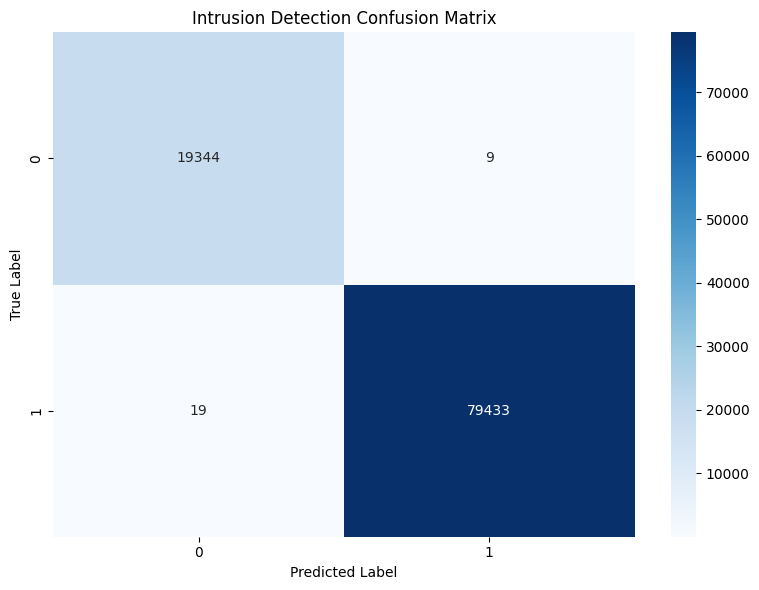

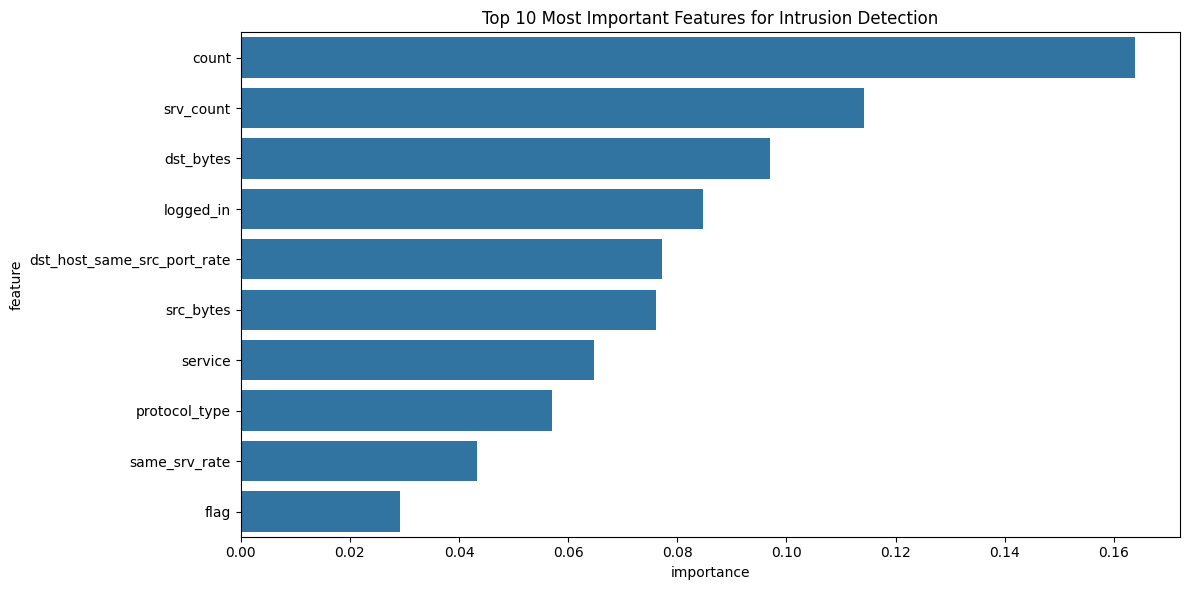


Detailed Attack Type Analysis:
                  total_samples  detected_attacks  detection_rate
original_label                                                   
back.                      2203              2203      100.000000
buffer_overflow.             30                28       93.333333
ftp_write.                    8                 8      100.000000
guess_passwd.                53                52       98.113208
imap.                        12                11       91.666667
ipsweep.                   1247              1246       99.919808
land.                        21                21      100.000000
loadmodule.                   9                 9      100.000000
multihop.                     7                 7      100.000000
neptune.                 107201            107201      100.000000
nmap.                       231               230       99.567100
normal.                   97278                 9        0.009252
perl.                         3             

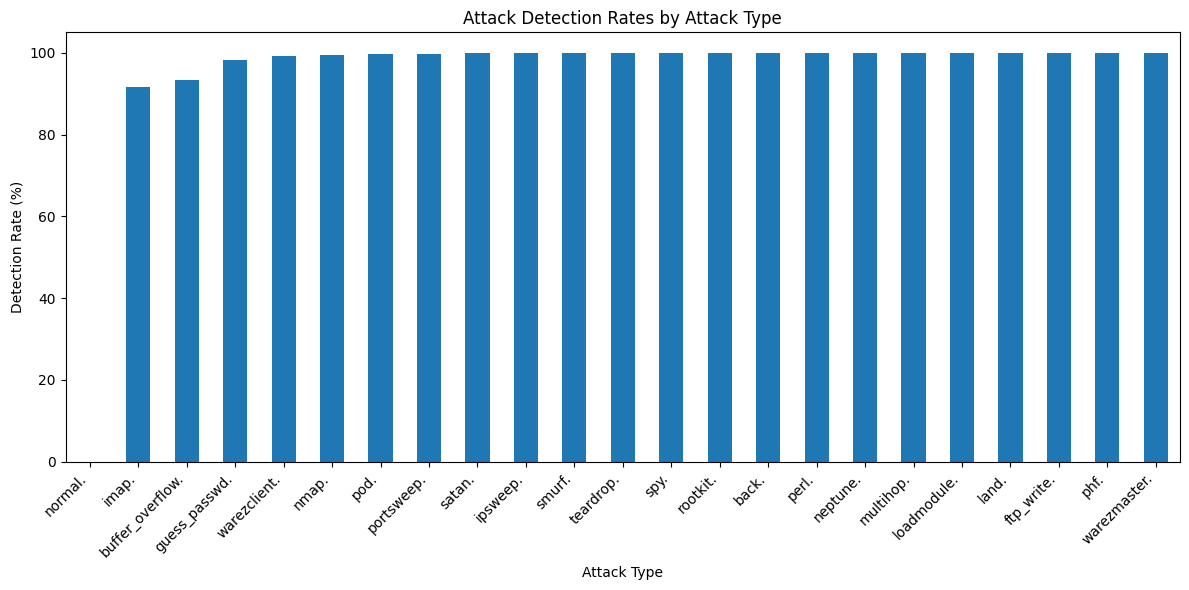

Model saved successfully!


In [22]:
if __name__ == "__main__":
    main()

In [23]:
from google.colab import files

# Download the saved model file
files.download("intrusion_detection_model.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>